Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/08 09:52:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Age group and Sex Query results:


+-------------+----------+------------------+
|    Age_group|       Sex|  avg_hearing_loss|
+-------------+----------+------------------+
| Ages 6 to 11|Both sexes|11.072222232818604|
| Ages 6 to 79|Both sexes| 37.72222211625841|
| Ages 6 to 79|   Females|32.861111111111114|
| Ages 6 to 11|   Females|11.727777772479588|
| Ages 6 to 79|     Males| 42.67777760823568|
| Ages 6 to 11|     Males|12.208333373069763|
|Ages 12 to 19|Both sexes|10.611111243565878|
|Ages 12 to 19|   Females|10.205555491977268|
|Ages 12 to 19|     Males|11.666666613684761|
|Ages 20 to 39|Both sexes|18.500000052981907|
|Ages 20 to 39|   Females|13.850000143051147|
|Ages 20 to 39|     Males| 24.34999985165066|
|Ages 40 to 59|Both sexes| 45.71666685740153|
|Ages 40 to 59|   Females|38.105555852254234|
|Ages 40 to 59|     Males|53.483333587646484|
|Ages 60 to 79|Both sexes| 79.26111072964139|
|Ages 60 to 79|   Females|  73.8777781592475|
|Ages 60 to 79|     Males| 84.41111140780978|
+-------------+----------+--------

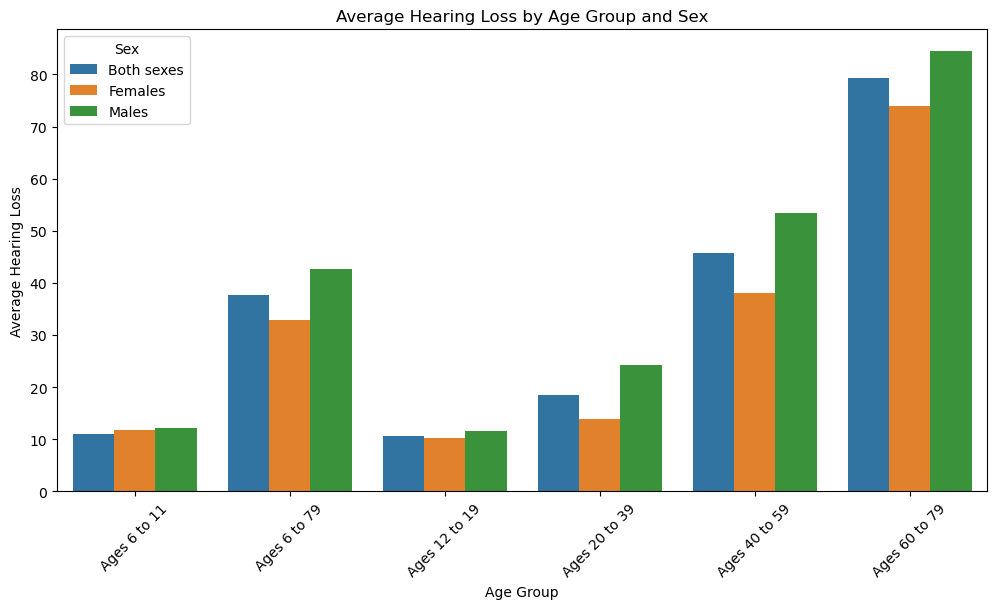

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

spark = SparkSession.builder.appName("Hearing Loss Analysis").getOrCreate()

path = "/Users/akankshasathish/Downloads/13100748new.csv"
df = spark.read.csv(path, header=True, inferSchema=True).cache()

df = df.withColumn("VALUE", col("VALUE").cast("float"))

df.createOrReplaceTempView("hearing_loss_data")


age_sex_query = spark.sql("""
    SELECT Age_group, Sex, AVG(VALUE) as avg_hearing_loss
    FROM hearing_loss_data
    WHERE Categories = 'Hearing loss'
    Group BY Age_group, Sex
    ORDER BY CAST(SUBSTR(Age_group, 6, INSTR(Age_group, ' to') -6) AS INT), Sex
""")
print("Age group and Sex Query results:")
age_sex_query.show()
age_sex_data = age_sex_query.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x= 'Age_group', y='avg_hearing_loss', hue='Sex', data=age_sex_data)
plt.title('Average Hearing Loss by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Average Hearing Loss')
plt.xticks(rotation=45)
plt.show()

Rate of Change Query results:
+-------------+-------------------+
|    Age_group|     rate_of_change|
+-------------+-------------------+
| Ages 6 to 11| 0.4074074074074074|
| Ages 6 to 79| 0.7888888606318721|
|Ages 12 to 19|0.39074074780499496|
|Ages 20 to 39| 0.8018518377233435|
|Ages 40 to 59| 1.3111111676251446|
|Ages 60 to 79| 0.8185186032895688|
+-------------+-------------------+



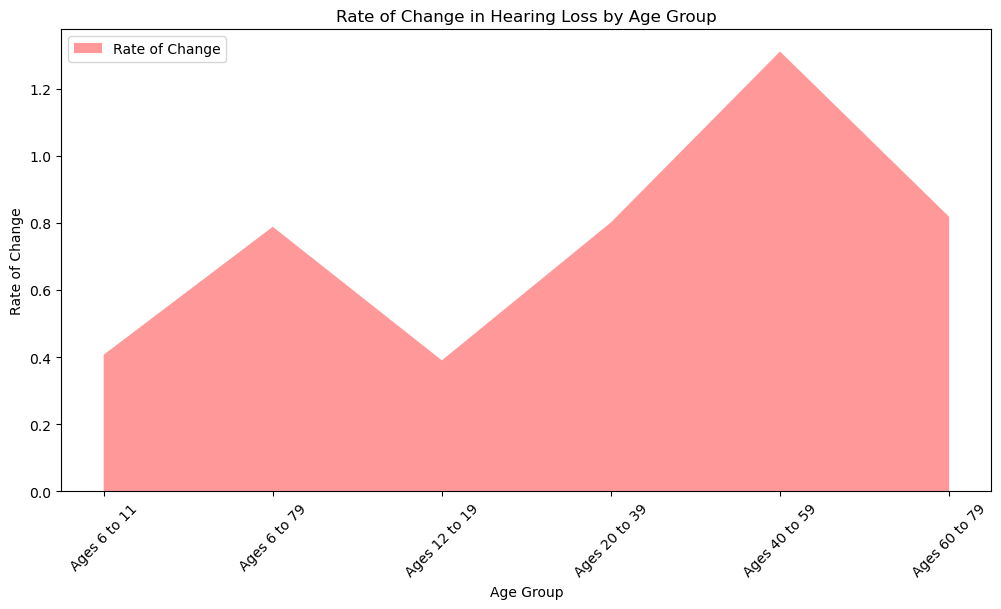

In [2]:
rate_of_change_query = spark.sql("""
    SELECT Age_group,
      (MAX(VALUE) - MIN(VALUE)) / COUNT(*) as rate_of_change
    FROM hearing_loss_data
    WHERE Categories = 'Hearing loss'
    GROUP BY Age_group
    ORDER BY CAST(SUBSTR(Age_group, 6, INSTR(Age_group, ' to') -6) AS INT)
""")
print("Rate of Change Query results:")
rate_of_change_query.show()
rate_of_change_data = rate_of_change_query.toPandas()

plt.figure(figsize=(12,6))
plt.stackplot(rate_of_change_data['Age_group'], rate_of_change_data['rate_of_change'], labels=['Rate of Change'], colors=['#ff9999'])
plt.title('Rate of Change in Hearing Loss by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Rate of Change')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

Year Query Results:


+--------+------------------+
|REF_DATE|  avg_hearing_loss|
+--------+------------------+
|    2013|33.835897439565414|
|    2015|34.999382807884686|
+--------+------------------+



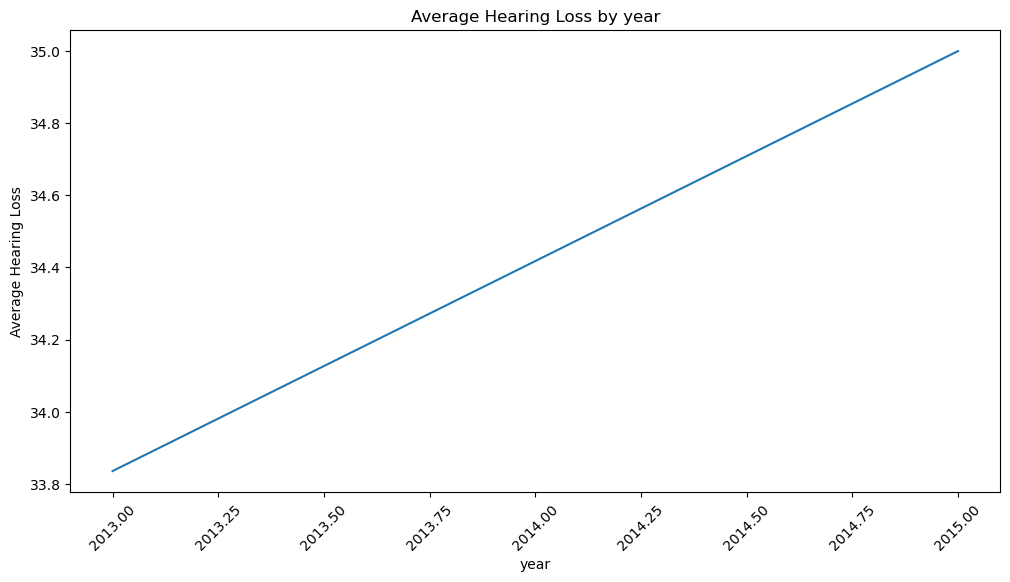

In [3]:
year_query = spark.sql("""
    SELECT REF_DATE, AVG(VALUE) as avg_hearing_loss
    FROM hearing_loss_data
    WHERE Categories = 'Hearing loss'
    GROUP BY REF_DATE
    ORDER BY REF_DATE
""")
print("Year Query Results:")
year_query.show()
year_data = year_query.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='REF_DATE', y='avg_hearing_loss', data=year_data)
plt.title('Average Hearing Loss by year')
plt.xlabel('year')
plt.ylabel('Average Hearing Loss')
plt.xticks(rotation=45)
plt.show() 

Geography Query Results:
+------+-----------------+
|   GEO| avg_hearing_loss|
+------+-----------------+
|Canada|34.42861640078467|
+------+-----------------+



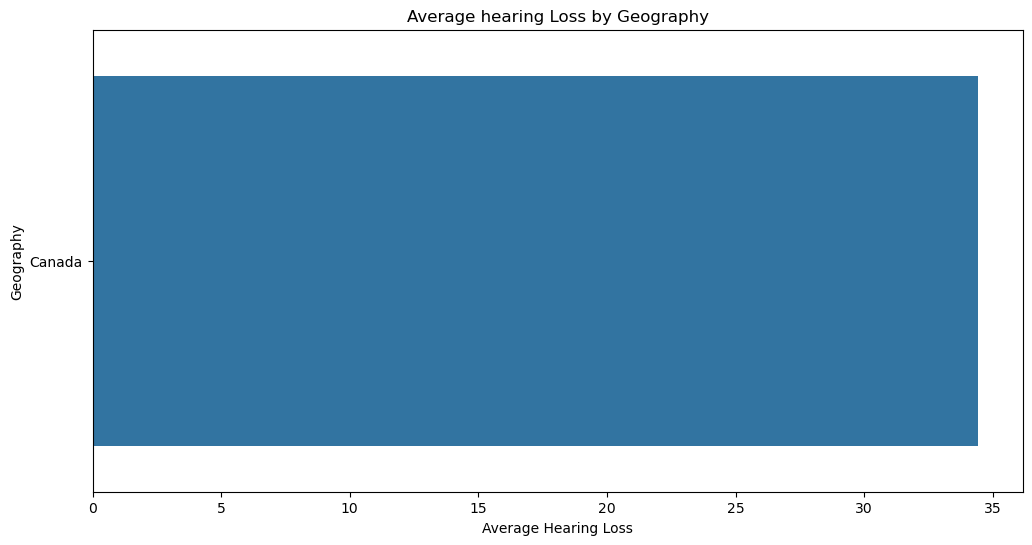

In [4]:
geo_query = spark.sql("""
    SELECT GEO, AVG(VALUE) as avg_hearing_loss
    FROM hearing_loss_data
    WHERE Categories = 'Hearing loss'
    GROUP BY GEO
    ORDER BY avg_hearing_loss DESC
""")
print("Geography Query Results:")
geo_query.show()
geo_data = geo_query.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x='avg_hearing_loss', y='GEO', data=geo_data)
plt.title('Average hearing Loss by Geography')
plt.xlabel('Average Hearing Loss')
plt.ylabel('Geography')
plt.show() 

Confidence Query Results:
+--------+------------------+------------------+-------------------+
|REF_DATE|      avg_estimate|avg_low_confidence|avg_high_confidence|
+--------+------------------+------------------+-------------------+
|    2013|33.835897439565414|28.180769131733822| 39.775000205406776|
|    2015|34.999382807884686|29.942592444243253|  40.28148188414397|
+--------+------------------+------------------+-------------------+



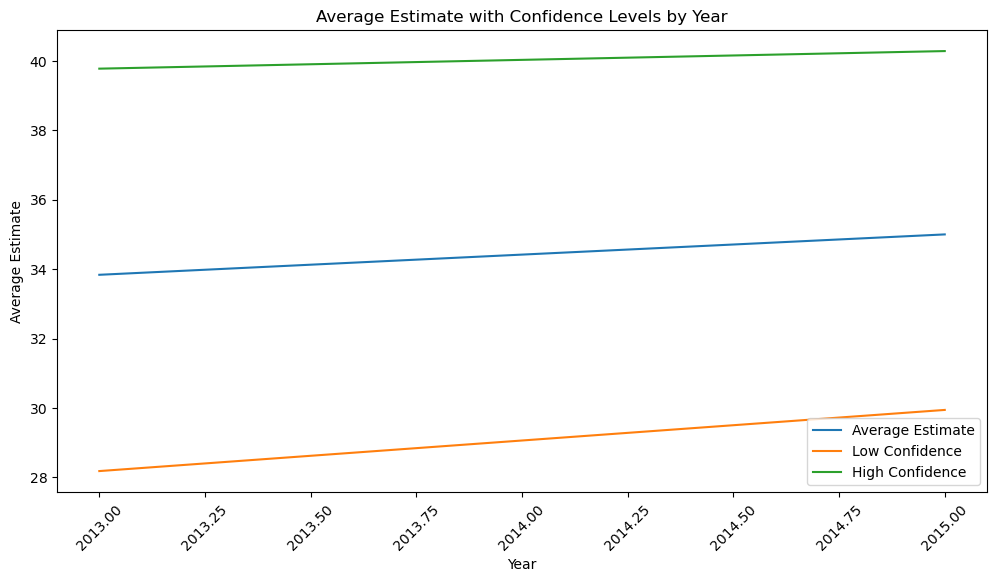

In [5]:
confidence_query = spark.sql("""
    SELECT REF_DATE, AVG(VALUE) as avg_estimate,
           AVG(CASE WHEN Characteristics LIKE '%Low%' THEN VALUE END) as avg_low_confidence,
           AVG(CASE WHEN Characteristics LIKE '%High%' THEN VALUE END) as avg_high_confidence
    FROM hearing_loss_data
    WHERE Categories = 'Hearing loss'
    GROUP BY REF_DATE
    ORDER BY REF_DATE 
 """)
print("Confidence Query Results:")
confidence_query.show()
confidence_data = confidence_query.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='REF_DATE', y='avg_estimate', data=confidence_data, label='Average Estimate')
sns.lineplot(x='REF_DATE', y='avg_low_confidence', data=confidence_data, label='Low Confidence')
sns.lineplot(x='REF_DATE', y='avg_high_confidence', data=confidence_data, label='High Confidence')
plt.title('Average Estimate with Confidence Levels by Year')
plt.xlabel('Year')
plt.ylabel('Average Estimate')
plt.xticks(rotation=45)
plt.legend()
plt.show() 

        Age_group         Sex    Variance  Std_Deviation       Mean        CV
9    Ages 6 to 11  Both sexes   18.196451       4.265730  11.072222  0.385264
10   Ages 6 to 11     Females   29.445341       5.426356  11.727778  0.462693
11   Ages 6 to 11       Males   19.800764       4.449805  12.208333  0.364489
12   Ages 6 to 79  Both sexes   80.960619       8.997812  37.722222  0.238528
13   Ages 6 to 79     Females   74.661261       8.640675  32.861111  0.262945
14   Ages 6 to 79       Males  104.666167      10.230648  42.677778  0.239718
0   Ages 12 to 19  Both sexes   15.663211       3.957677  10.611111  0.372975
1   Ages 12 to 19     Females   20.811635       4.561977  10.205555  0.447009
2   Ages 12 to 19       Males   31.047777       5.572053  11.666667  0.477605
3   Ages 20 to 39  Both sexes   54.088889       7.354515  18.500000  0.397541
4   Ages 20 to 39     Females   63.219169       7.951048  13.850000  0.574083
5   Ages 20 to 39       Males  107.694718      10.377607  24.350

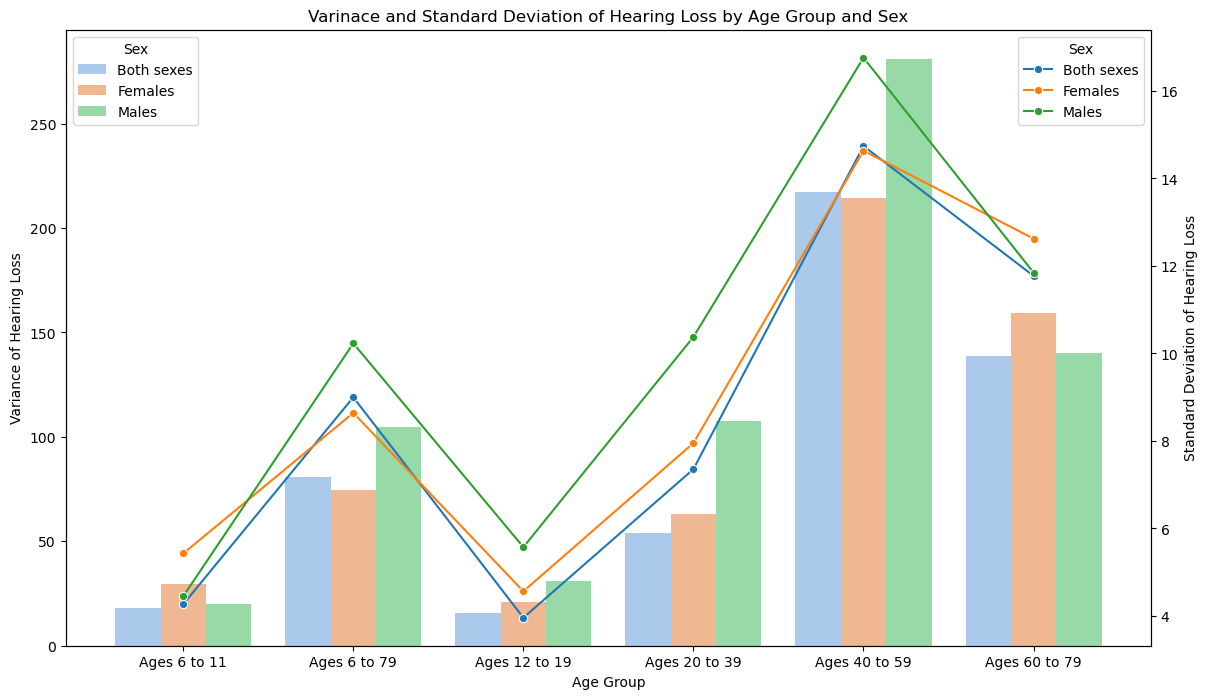

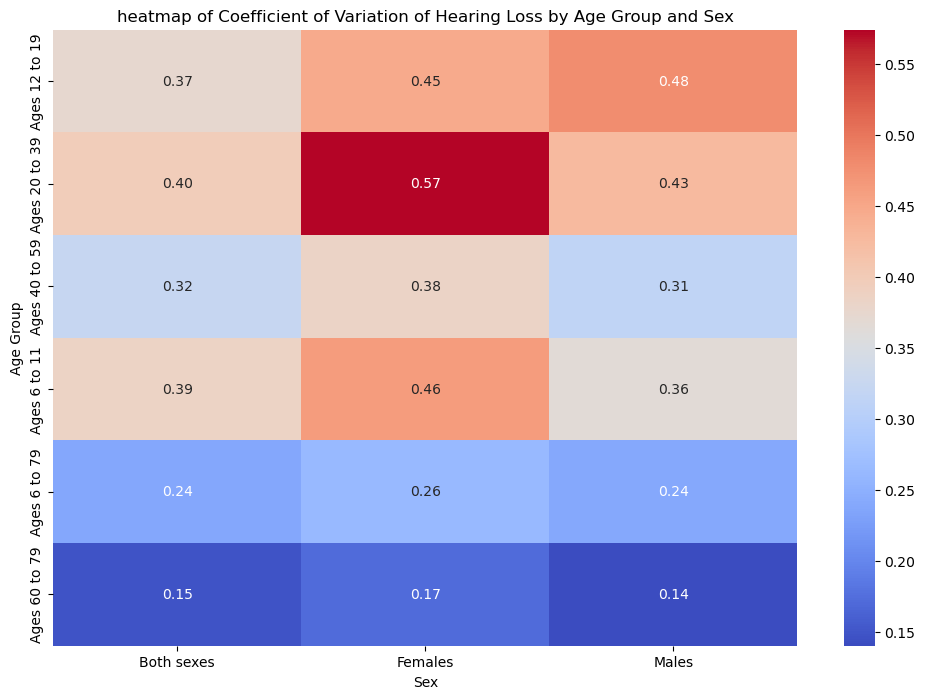

In [6]:
data_query = spark.sql("""
      SELECT  Age_group, Sex, VALUE
      FROM hearing_loss_data
      WHERE Categories = 'Hearing loss'
""")
info_df = data_query.toPandas()

info_df['VALUE'].replace('',np.nan, inplace=True)
info_df.dropna(subset=['VALUE'], inplace=True)

def calculate_variance(values):
    mean_data = sum(values) / len(values)
    return sum((x - mean_data) ** 2 for x in values) / len(values)

def calculate_std_dev(variance):
    return math.sqrt(variance)

results = []
 
grouped_data = info_df.groupby(['Age_group', 'Sex'])

for (age_group, sex), group in grouped_data :
    values = group['VALUE'].tolist()
    if len(values) > 1:
        variance = calculate_variance(values)
        std_dev = calculate_std_dev(variance)
        mean_data = sum(values) / len(values)
        if not math.isnan(variance) and variance > 0:
            cv = std_dev / mean_data
            results.append({
                'Age_group' : age_group,
                'Sex': sex,
                'Variance': variance,
                'Std_Deviation' : std_dev,
                'Mean' : mean_data,
                'CV' : cv
            })
results_df = pd.DataFrame(results)

results_df['Age_group_num'] = results_df['Age_group'].str.extract(r'(\d+)').astype(int)
results_df.loc[results_df['Age_group'] == 'Ages 6 to 79', 'Age_group_num'] = 11
results_df.sort_values(by=['Age_group_num', 'Sex'], inplace=True)
results_df.drop('Age_group_num', axis=1, inplace=True)
print(results_df)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Age_group', y='Variance', hue='Sex', data=results_df, palette='pastel')
ax2 = ax.twinx()
sns.lineplot(x='Age_group', y='Std_Deviation', hue='Sex', data=results_df, marker='o', ax=ax2)
ax.set_title('Varinace and Standard Deviation of Hearing Loss by Age Group and Sex')
ax.set_xlabel('Age Group')
ax.set_ylabel('Variance of Hearing Loss')
ax2.set_ylabel('Standard Deviation of Hearing Loss')
ax.legend(title='Sex', loc='upper left')
ax2.legend(title= 'Sex', loc='upper right')
plt.show()

pivot_table = results_df.pivot(index="Age_group", columns="Sex", values="CV")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('heatmap of Coefficient of Variation of Hearing Loss by Age Group and Sex')
plt.ylabel('Age Group')
plt.xlabel('Sex')
plt.show()

Quartile Hearing Query Results: 
+-------------+---------------+-------------------+---------------+
|    Age_group|Q1_hearing_loss|median_hearing_loss|Q3_hearing_loss|
+-------------+---------------+-------------------+---------------+
| Ages 6 to 11|            7.9|               10.4|           14.7|
| Ages 6 to 79|           30.1|               34.8|           45.1|
|Ages 12 to 19|            7.3|                9.4|           13.6|
|Ages 20 to 39|           11.7|               16.6|           22.9|
|Ages 40 to 59|           33.9|               41.4|           58.9|
|Ages 60 to 79|           68.8|               78.1|           90.9|
+-------------+---------------+-------------------+---------------+



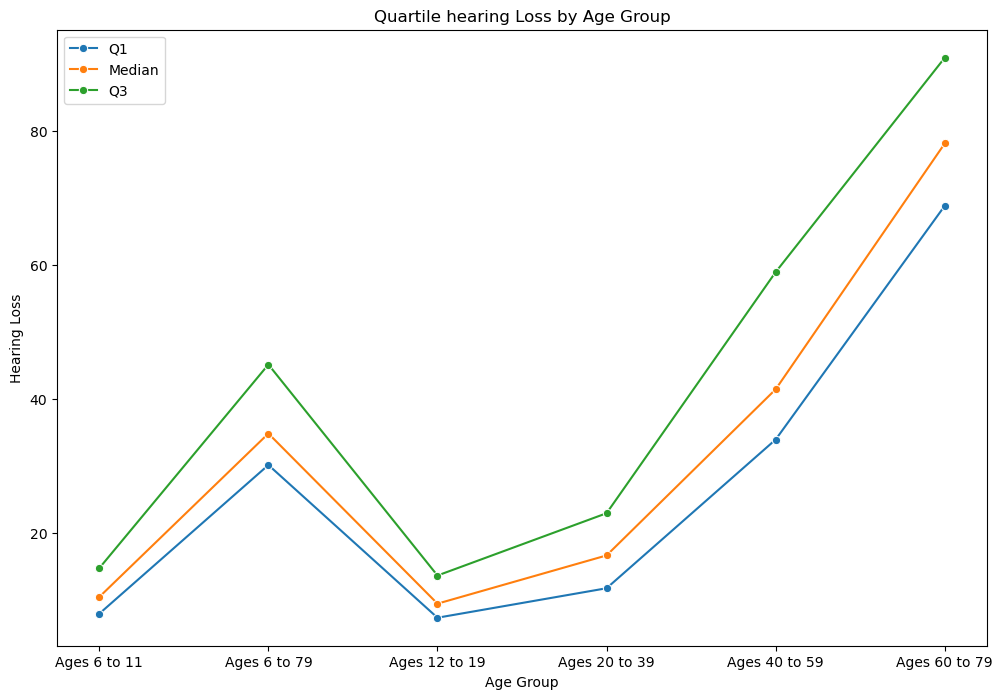

In [7]:
Quartile_hearing_query = spark.sql("""
            SELECT Age_group,
                percentile_approx(VALUE, 0.25) as Q1_hearing_loss,
                percentile_approx(VALUE, 0.50) as median_hearing_loss,
                percentile_approx(VALUE, 0.75) as Q3_hearing_loss
FROM hearing_loss_data
WHERE Categories = 'Hearing loss'
GROUP BY Age_group
ORDER BY CAST(SUBSTR(Age_group, 6, INSTR(Age_group, ' to') -6) AS INT)
""")
print("Quartile Hearing Query Results: ")
Quartile_hearing_query.show()
Quartile_hearing_data = Quartile_hearing_query.toPandas()

plt.figure(figsize=(12,8))
sns.lineplot(data=Quartile_hearing_data, x='Age_group', y='Q1_hearing_loss', marker='o', label='Q1')
sns.lineplot(data=Quartile_hearing_data, x='Age_group', y='median_hearing_loss', marker='o', label='Median')
sns.lineplot(data=Quartile_hearing_data, x='Age_group', y='Q3_hearing_loss', marker='o', label='Q3')
plt.title('Quartile hearing Loss by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Hearing Loss')
plt.legend()
plt.show()